###Objective

Predict adult female (18+) anemia status in the US.



####Target vector: Anemia

'According to the World Health Organization (WHO), anemia is defined as `hemoglobin (Hb)` levels `<12.0 g/dL` in women and `<13.0 g/dL` in men.

Source: https://www.sciencedirect.com/science/article/abs/pii/S0037196315000621 

####Features (independent variables):

age, height, weight, education, race, family income to poverty ratio,dominant hand, arm circumference, arm lenghth in cm,	leg length in cm,  waist circumference	

#### Data

National Health and Nutrition Examination Survey (NHANES) 2013-2014

source:https://www.kaggle.com/datasets/cdc/national-health-and-nutrition-examination-survey

In [2]:
%%capture
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*

In [3]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Data Wrangling**

In [10]:
def wrangle(me):
  df=pd.read_csv(me, index_col='id').sort_index()
  df.drop(['Unnamed: 0'], axis=1, inplace=True)

  # select only demographic features:
  df=df[['age','race','education','pregnancy','inc_poverty_ratio',
  'weight','head_circum','height',
  'leg_cm','arm_cm','arm_circum','waist_circum','pregnant_or_breastfeeding','hemoglobin']]
  # filter observations with age>18 years of age
  df = df[df['age'] >=18] 

  # drop columns with NaN values (>50%)
  df.dropna(axis=1, thresh=2431, inplace = True)

  # create target vector (anemia), and drop 'hemoglobin'
  df.loc[(df['hemoglobin'] <12), 'anemia'] = 1
  df.loc[(df['hemoglobin'] >=12), 'anemia'] = 0
  # dropping hemoglobing to avoid data leakage
  df.drop(columns= ['hemoglobin'], inplace=True)
  df.dropna(axis=0, how='any', inplace=True)

  # sort column by their names
  df = df.reindex(sorted(df.columns), axis=1)

  return df

df = wrangle('/content/females.csv')


In [12]:
print(df.shape)
df.head()

(2427, 11)


,age,anemia,arm_circum,arm_cm,education,height,inc_poverty_ratio,leg_cm,race,waist_circum,weight
id,,,,,,,,,,,
73564,61,0.0,38.0,39.3,5.0,161.8,5.00,37.1,3,110.8,93.4
73566,56,0.0,29.0,33.5,3.0,152.8,0.48,32.4,3,85.5,61.8
73568,26,0.0,25.8,32.6,5.0,152.5,5.00,34.4,3,73.7,47.1
73574,33,1.0,26.5,33.4,5.0,158.0,2.10,37.5,6,78.7,56.8
73596,57,0.0,37.2,37.6,5.0,164.7,5.00,35.3,6,117.8,104.0


**ProfileReport**

In [ ]:
from pandas_profiling import ProfileReport

report = ProfileReport(df, minimal=True).to_notebook_iframe()
report

**Define Feature Matrix and Target Variable**

In [15]:
target = 'anemia'
X = df.drop(columns=target)
y=df[target]

df.shape, X.shape, y.shape

((2427, 11), (2427, 10), (2427,))

In [16]:
y.value_counts()

0.0    2112
1.0     315
Name: anemia, dtype: int64

Sinve the target values is not balanced. I am gonna balance it using SMOTE - Synthetic Minority Oversampling Technique 

### Train_Test split 

In [17]:
X_train_, X_test, y_train_, y_test = train_test_split(X, y , test_size=0.2)

In [18]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train_, y_train_)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0.0: 2112, 1.0: 315})
Resample dataset shape Counter({0.0: 1687, 1.0: 1687})


In [19]:
# Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.25)

In [20]:
X_train.shape, y_train.shape, X_val.shape,y_val.shape

((2530, 10), (2530,), (844, 10), (844,))

In [21]:
print('baseline accuracy:', y_train.value_counts(normalize=True).max())

baseline accuracy: 0.5007905138339921


In [22]:
model_randomf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model_randomf.fit(X_train, y_train);

In [23]:
print('FOREST: Training Accuracy:',model_randomf.score(X_train, y_train))
print('FOREST: Validation Accuracy:',model_randomf.score(X_val, y_val))
print('FOREST: Test Accuracy:',model_randomf.score(X_test, y_test))

FOREST: Training Accuracy: 1.0
FOREST: Validation Accuracy: 0.9229857819905213
FOREST: Test Accuracy: 0.831275720164609


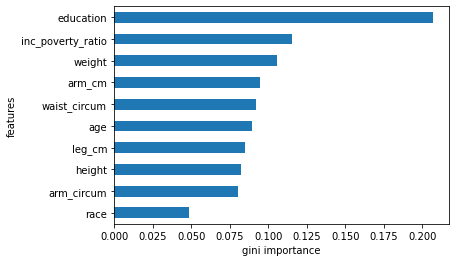

In [24]:
# What are the most important features? 
features = model_randomf.named_steps['ordinalencoder'].get_feature_names()
gini = model_randomf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(11).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

Cross Validation Score for the Random Forest model:

In [25]:
cv_scores_rf = cross_val_score(model_randomf, X, y, cv=10,n_jobs=-1)

In [26]:
print('CV score RandomForestClassifier')
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
Mean CV accuracy score: 0.8681478080467981
STD CV accuracy score: 0.005869552471159816


Do a GridSearch:

In [ ]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(50, 100, 50),
    'randomforestclassifier__max_features': range(5, 11, 1),
    'randomforestclassifier__n_estimators': range(100, 300, 50)
}

model_rfgrid = GridSearchCV(
    clf,
    param_grid = param_grid,
    n_jobs=-1,
    cv=None,
    verbose=1 
)

model_rfgrid.fit(X, y)

Get the best estimators from a Gridsearch: 

In [ ]:
model_rfgrid.best_estimator_ 

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=50, max_features=5,
                                        n_estimators=250, n_jobs=-1,
                                        random_state=42))])

Apply the best estimators in the model and run it again.

In [30]:
model_rf_tuned = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        max_depth=50,max_features=5 ,n_estimators=140,
        random_state=42, n_jobs=-1)
)

model_rf_tuned.fit(X_train, y_train);

In [31]:
print('Training Accuracy:',model_rf_tuned.score(X_train, y_train))
print('Validation Accuracy:',model_rf_tuned.score(X_val, y_val))
print('Test Accuracy:',model_rf_tuned.score(X_test, y_test))

Training Accuracy: 1.0
Validation Accuracy: 0.9312796208530806
Test Accuracy: 0.8436213991769548


Classification Report with Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


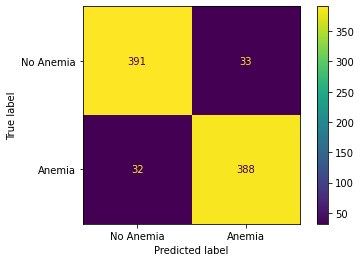

In [35]:

from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(
    model_randomf,
    X_val, 
    y_val, 
    values_format ='.0f',
    display_labels = ['No Anemia', 'Anemia']
);